In [58]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
import random

In [2]:
images = np.load('object_images.npy')

In [3]:
voxels = np.load('object_voxels_filtered_0.npy')

In [4]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()

In [56]:
train_images = images[1:2000]
val_images = images[2000:2010]
train_voxels = voxels[1:2000]
val_voxels = voxels[2000:2010]

Displaying the object


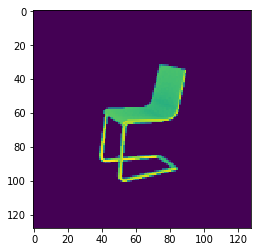

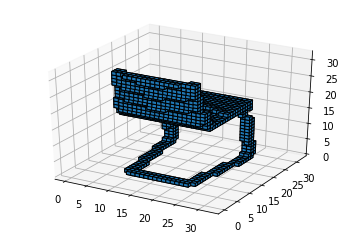

In [57]:
display_id = 56
batch_size = 1
train_data = [train_voxels, train_images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(train_images[display_id][0])
display3DObject(train_voxels[display_id])

In [5]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, sigma
        

In [40]:
class aggregator(nn.Module):
    def __init__(self, z_size=200, h_dim=100, n_layers=1, batch_size=1):
        super(aggregator, self).__init__()
        self.h_dim, self.h_dim, self.n_layers= z_size, h_dim, n_layers
        self.lstm = nn.LSTM(input_size=z_size, hidden_size=h_dim, num_layers=n_layers)
        self.hidden_to_z_size = nn.Linear(self.h_dim, z_size)
        self.reInitialize(batch_size)
        
    def reInitialize(self, batch_size):
        # Size = (num_layers, minibatch_size, hidden_dim)
        self.hidden = (Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda(), Variable(torch.zeros(self.n_layers,batch_size,self.h_dim)).cuda())
    
    def setHiddenState(self, hidden):
        self.hidden = hidden
        
    def forward(self, x):
#         for i in range(seqn):
#             concat_vec = torch.cat((current_state, actions[i]),0).view(1,1,-1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        output_state = self.hidden_to_z_size(lstm_out[0,0,:])
        current_state = output_state

        return current_state, self.hidden

In [63]:
class MVRNN(nn.Module):
    def __init__(self, z_size=200, batch_size=1):
        super(MVRNN, self).__init__()
        self.z_size = z_size
        self.batch_size = batch_size
        self.vae = VAE()
        self.agg = aggregator()
        
    def forward(self, x, seqn):
        # x is [Sequence, Batch, channel, h, w]
        self.agg.reInitialize(self.batch_size)
        current_state = None
        for i in range(seqn):
            mu, sigma= self.vae.encoder(x[i])
            latent = self.vae.reparametrize(mu,sigma)

            #latent = latent.view(-1,self.z_size,1,1,1)
            latent = latent.view(1,self.batch_size,self.z_size)
            #print("Latent Shape", latent.shape)
            current_state, current_hidden = self.agg.forward(latent)
            self.agg.setHiddenState(current_hidden)
        #print("Latent Shape", current_state.shape)
        latent = current_state.view(-1,self.z_size,1,1,1)
        object_3D = self.vae.decoder(latent)
        return object_3D, mu, sigma
            
        

In [64]:
mvrnn = MVRNN().cuda()
lr_vae = 0.003
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
mvrnn_solver = optim.Adam(mvrnn.parameters(), lr=lr_vae, betas = adam_beta_vae)

In [82]:
#Training the mvcnn arch 
num_epochs = 500
max_seq_len = 12
val_images = torch.FloatTensor(val_images)
val_voxels = torch.FloatTensor(val_voxels)
loss = nn.BCELoss(size_average=False)
for epoch in range(num_epochs):
    mvvae_losses = []
    klds = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        seq_len = random.randint(1,max_seq_len-1)
        var_3D_data = Variable(data3d).cuda().float()
        var_2D_data = Variable(data2d).cuda().float().view(max_seq_len,1,1,128,128)
        generated_object, mu, logvar = mvrnn(var_2D_data, seq_len)
        generated_object = generated_object.squeeze()
            # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#         KLD_element = mu.pow(2).add_(sigma.exp()).mul_(-1).add_(1).add_(sigma)
#         KLD = torch.sum(KLD_element).mul_(-0.5)
        # https://arxiv.org/abs/1312.6114
        #print(logvar.shape)
        KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #rint(KLD)
        loss_ = loss(generated_object, var_3D_data) + KLD
        mvrnn.zero_grad()
        loss_.backward()
        mvrnn_solver.step()
        mvvae_losses.append(loss_)
        klds.append(KLD)
    random_val = random.randint(1,10-1)
    seq_len = random.randint(1,max_seq_len-1)
    val_3D_data = Variable(val_voxels[random_val]).cuda().float()
    val_2D_data = Variable(val_images[random_val]).cuda().float().view(max_seq_len,1,1,128,128)
    generated_object_val, mu, sigma = mvrnn(val_2D_data,seq_len)
    generated_object_val = torch.round(generated_object_val.squeeze())
    accuracy = np.mean((generated_object_val  == val_3D_data).squeeze().data.cpu().numpy())
    mvvae_losses_mean = np.mean(np.concatenate(mvvae_losses))
    kld_mean =  np.mean(np.concatenate(klds)).data.cpu().numpy()[0]
    print("Epoch: ", epoch, '\n', "MV RNN loss: ", mvvae_losses_mean.data.cpu().numpy()[0])
    print("Accuracy", accuracy, "KLD loss: ", kld_mean)

/home/adityasan92/anaconda2/envs/pytorch/lib/python3.5/site-packages/torch/nn/functional.py:1189: UserWarning: Using a target size (torch.Size([1, 32, 32, 32])) that is different to the input size (torch.Size([32, 32, 32])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:  0 
 MV RNN loss:  7822.6567
Accuracy 0.785614013671875 KLD loss:  63.229687
Epoch:  1 
 MV RNN loss:  7703.567
Accuracy 0.781951904296875 KLD loss:  61.86974
Epoch:  2 
 MV RNN loss:  7711.7754
Accuracy 0.828521728515625 KLD loss:  60.485394
Epoch:  3 
 MV RNN loss:  7743.506
Accuracy 0.786376953125 KLD loss:  69.65131
Epoch:  4 
 MV RNN loss:  7613.461
Accuracy 0.71527099609375 KLD loss:  70.14814
Epoch:  5 
 MV RNN loss:  7673.7715
Accuracy 0.77960205078125 KLD loss:  69.80734
Epoch:  6 
 MV RNN loss:  7733.865
Accuracy 0.65362548828125 KLD loss:  73.47385
Epoch:  7 
 MV RNN loss:  7642.773
Accuracy 0.862335205078125 KLD loss:  70.72672
Epoch:  8 
 MV RNN loss:  7658.556
Accuracy 0.846282958984375 KLD loss:  74.604385
Epoch:  9 
 MV RNN loss:  7608.524
Accuracy 0.65496826171875 KLD loss:  74.735176
Epoch:  10 
 MV RNN loss:  7587.1772
Accuracy 0.762603759765625 KLD loss:  72.764206
Epoch:  11 
 MV RNN loss:  7562.043
Accuracy 0.7867431640625 KLD loss:  68.41671


KeyboardInterrupt: 

torch.Size([12, 1, 1, 128, 128])
Displaying the object


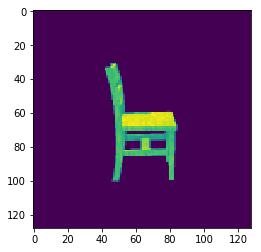

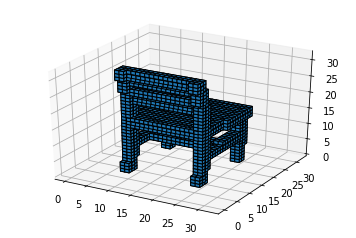

Displaying the object


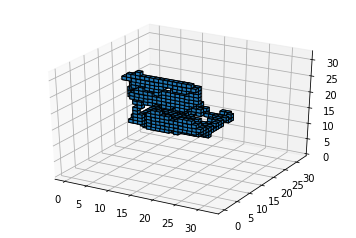

In [85]:
# #Testing the mvcnn architecture 

# mvcn = mvcnn().cuda()

#print(val_images[1:2])
i = 4100
seq = 12
test_image = Variable(torch.FloatTensor(images[i:i+1])).cuda()
test_image = test_image[0][0:seq].view(seq,1,1,128,128)
print(test_image.shape)
# #test_image = test_image[0][0:1].unsqueeze(1)
# print(test_image.shape) 

test_object, _, _ = mvrnn(test_image, seq)

plt.imshow(images[i][0])
# display3DObject(Variable(voxels[i]).data.cpu().numpy())
display3DObject(voxels[i])
display3DObject(test_object.squeeze().data.cpu().numpy()>0.5)

In [60]:
max_seq_len = 12
for batch_idx, (data3d, data2d) in enumerate(train_loader):
    var_2D_data = Variable(data2d).cuda().float()
    print(var_2D_data.view(max_seq_len,1,1,128,128).shape)

torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size

torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size([12, 1, 1, 128, 128])
torch.Size

In [53]:
#Testing the RNN 
mvrnn = MVRNN().cuda()
test_image = Variable(torch.FloatTensor(images[0])).unsqueeze(1).unsqueeze(1).cuda()
print(test_image.shape)
object_3d, _, _ = mvrnn.forward(test_image, 12)
object_3d.shape

torch.Size([12, 1, 1, 128, 128])
0
1
2
3
4
5
6
7
8
9
10
11
Latent Shape torch.Size([200])


torch.Size([1, 1, 32, 32, 32])

In [77]:
val_voxels.shape

torch.Size([10, 32, 32, 32])

In [80]:
val_images[3][4].shape

torch.Size([128, 128])